<p style="align: center;"><img align=center src="https://drive.google.com/uc?export=view&id=1TRNaCfYstvcIQqoUSdukYQGF6LuyL7Tv" width=600 height=320/></p>
<h3 style="text-align: center;"><b>Школа глубокого обучения ФПМИ МФТИ</b></h3>

# Домашнее задание. Автоэнкодеры


# Часть 1. Vanilla Autoencoder (10 баллов)

## 1.1. Подготовка данных (0.5 балла)


In [ ]:
import numpy as np
from torch.autograd import Variable
from torchvision import datasets, transforms
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.utils.data as data_utils
import torch
import matplotlib.pyplot as plt

import os
import pandas as pd
import skimage.io
from skimage.transform import resize
from sklearn.model_selection import train_test_split
from IPython import display

%matplotlib inline

In [ ]:
def fetch_dataset(attrs_name = "lfw_attributes.txt",
                      images_name = "lfw-deepfunneled",
                      dx=80,dy=80,
                      dimx=64,dimy=64
    ):

    #download if not exists
    if not os.path.exists(images_name):
        print("images not found, donwloading...")
        os.system("wget http://vis-www.cs.umass.edu/lfw/lfw-deepfunneled.tgz -O tmp.tgz")
        print("extracting...")
        os.system("tar xvzf tmp.tgz && rm tmp.tgz")
        print("done")
        assert os.path.exists(images_name)

    if not os.path.exists(attrs_name):
        print("attributes not found, downloading...")
        os.system("wget http://www.cs.columbia.edu/CAVE/databases/pubfig/download/%s" % attrs_name)
        print("done")

    #read attrs
    df_attrs = pd.read_csv("lfw_attributes.txt",sep='\t',skiprows=1,)
    df_attrs = pd.DataFrame(df_attrs.iloc[:,:-1].values, columns = df_attrs.columns[1:])


    #read photos
    photo_ids = []
    for dirpath, dirnames, filenames in os.walk(images_name):
        for fname in filenames:
            if fname.endswith(".jpg"):
                fpath = os.path.join(dirpath,fname)
                photo_id = fname[:-4].replace('_',' ').split()
                person_id = ' '.join(photo_id[:-1])
                photo_number = int(photo_id[-1])
                photo_ids.append({'person':person_id,'imagenum':photo_number,'photo_path':fpath})

    photo_ids = pd.DataFrame(photo_ids)
    # print(photo_ids)
    #mass-merge
    #(photos now have same order as attributes)
    df = pd.merge(df_attrs,photo_ids,on=('person','imagenum'))

    assert len(df)==len(df_attrs),"lost some data when merging dataframes"

    # print(df.shape)
    #image preprocessing
    all_photos =df['photo_path'].apply(skimage.io.imread)\
                                .apply(lambda img:img[dy:-dy,dx:-dx])\
                                .apply(lambda img: resize(img,[dimx,dimy]))

    all_photos = np.stack(all_photos.values)#.astype('uint8')
    all_attrs = df.drop(["photo_path","person","imagenum"],axis=1)

    return all_photos, all_attrs

In [ ]:
# The following line fetches you two datasets: images, usable for autoencoder training and attributes.
# Those attributes will be required for the final part of the assignment (applying smiles), so please keep them in mind


data, attrs = fetch_dataset()


Разбейте выборку картинок на train и val, выведите несколько картинок в output, чтобы посмотреть, как они выглядят, и приведите картинки к тензорам pytorch, чтобы можно было скормить их сети:

In [ ]:
class MyDataset(data_utils.Dataset):
    def __init__(self, data, targets):
        self.data = data
        self.targets = targets

    def __len__(self):
        return len(self.data)

    def __getitem__(self, index):
        x = self.data[index]
        return x.permute(2, 0, 1)


data_torch = torch.from_numpy(data).float()
X_train, X_val, y_train, y_val = train_test_split(data_torch, attrs, test_size=0.3, random_state=42)


train_set = MyDataset(X_train, y_train)
valid_set = MyDataset(X_val, y_val)


train_dataloader = data_utils.DataLoader(train_set, batch_size=64, shuffle=True)
valid_dataloader = data_utils.DataLoader(valid_set, batch_size=64, shuffle=False)

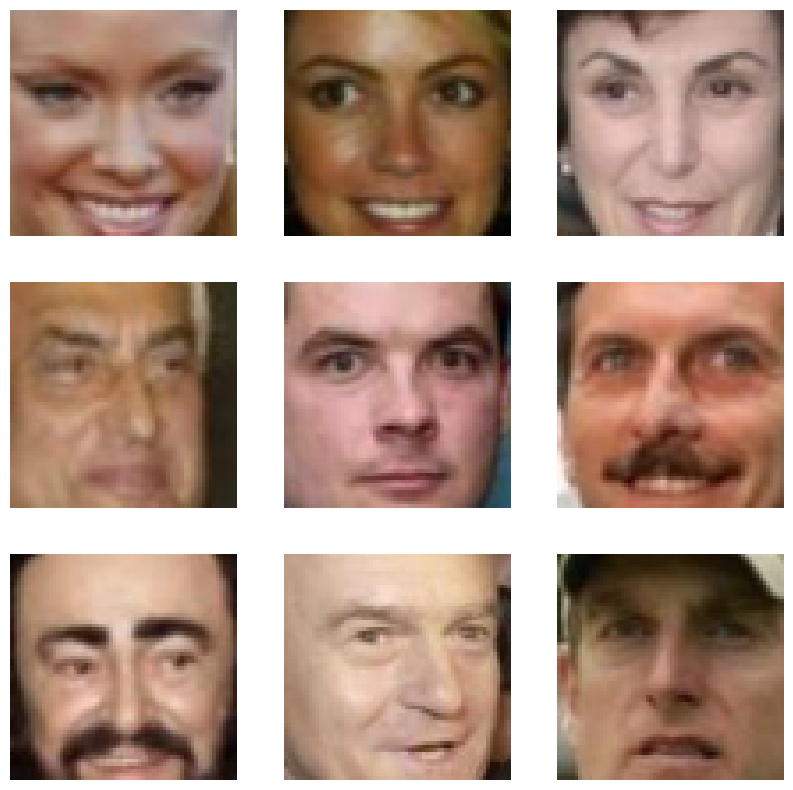

In [ ]:
def show_first_nine(images):
    images = images[:9]
    fg, axes = plt.subplots(3, 3)
    fg.set_size_inches(10, 10)
    for i, v in enumerate(axes.flatten()):
        v.imshow(images[i])
        v.axis("off")


show_first_nine(X_train)

## 1.2. Архитектура модели (1.5 балла)
В этом разделе мы напишем и обучем обычный автоэнкодер.



<img src="https://www.notion.so/image/https%3A%2F%2Fs3-us-west-2.amazonaws.com%2Fsecure.notion-static.com%2F4b8adf79-8e6a-4b7d-9061-8617a00edbb1%2F__2021-04-30__14.53.33.png?table=block&id=56f187b4-279f-4208-b1ed-4bda5f91bfc0&width=2880&userId=3b1b5e32-1cfb-4b0f-8705-5a524a8f56e3&cache=v2" alt="Autoencoder">


^ напомню, что автоэнкодер выглядит вот так

In [ ]:
dim_code = 32 # выберите размер латентного вектора
device = "cuda" if torch.cuda.is_available() else "cpu"

Реализуем autoencoder. Архитектуру (conv, fully-connected, ReLu, etc) можете выбирать сами. Экспериментируйте!

In [ ]:
from copy import deepcopy

class Autoencoder(nn.Module):
    def __init__(self, dim_code):
        super().__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(3, 16, kernel_size=3, stride=1, padding=1, padding_mode="reflect"),
            nn.ReLU(),
            nn.BatchNorm2d(16),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=1, padding_mode="reflect"),
            nn.ReLU(),
            nn.BatchNorm2d(32),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1, padding_mode="reflect"),
            nn.ReLU(),
            nn.BatchNorm2d(64),
            nn.Flatten(),
            nn.Linear(64*16*16, dim_code),
            nn.BatchNorm1d(dim_code)


        )

        self.decoder = nn.Sequential(
            nn.Linear(dim_code, 64*16*16),
            nn.Unflatten(1, (64,16,16)),
            nn.ConvTranspose2d(64, 32, kernel_size=1, stride=1),
            nn.ReLU(),
            nn.ConvTranspose2d(32, 16, kernel_size=2, stride=2),
            nn.ReLU(),
            nn.ConvTranspose2d(16, 3, kernel_size=2, stride=2),
            nn.Sigmoid()
        )



    def forward(self, x):
        latent_code = self.encoder(x)
        reconstruction = self.decoder(latent_code)
        # <реализуйте forward проход автоэнкодера
        # в качестве ваозвращаемых переменных -- латентное представление картинки (latent_code)
        # и полученная реконструкция изображения (reconstruction)>
        return reconstruction, latent_code

    def latent_to_image(self, latent):
        reconstruction = self.decoder(latent)
        return reconstruction

In [ ]:
criterion = nn.MSELoss()

autoencoder = Autoencoder(dim_code).to(device)

optimizer = torch.optim.AdamW(params=autoencoder.parameters())

## 1.3 Обучение (2 балла)

Осталось написать код обучения автоэнкодера. При этом было бы неплохо в процессе иногда смотреть, как автоэнкодер реконструирует изображения на данном этапе обучения. Наример, после каждой эпохи (прогона train выборки через автоэекодер) можно смотреть, какие реконструкции получились для каких-то изображений val выборки.

А, ну еще было бы неплохо выводить графики train и val лоссов в процессе тренировки =)

In [ ]:
def train(model, train_dataloader, valid_dataloader, loss_func, optimizer, epoch_number=10):
    train_loss_history, valid_loss_history = [], []
    history_reconstruction = []

    for epoch in range(1, epoch_number+1):
        model.train()
        train_loss = 0
        for image in train_dataloader:
            image = image.to(device)
            reconstruction, latent_code = model(image)
            loss = loss_func(image, reconstruction)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            train_loss += loss.cpu().item()
        train_loss = train_loss / len(train_dataloader)
        train_loss_history.append(train_loss)

        model.eval()
        valid_loss = 0
        with torch.no_grad():
            for image in valid_dataloader:
                image = image.to(device)
                reconstruction, latent_code = model(image)
                loss = loss_func(image, reconstruction)
                valid_loss += loss.cpu().item()
        valid_loss = valid_loss / len(valid_dataloader)
        valid_loss_history.append(valid_loss)

        fg, axes = plt.subplots(1, 8, gridspec_kw={'width_ratios': [4, 1,1,1,1,1,1,1]})
        fg.set_size_inches(22,2)
        fg.suptitle(f"Epoch {epoch}, loss_train: {train_loss:.4f}, loss_val: {valid_loss:.4f}")
        fg.subplots_adjust(wspace=0.1, hspace=0.1)

        axes[0].plot(valid_loss_history, label="valid")
        axes[0].plot(train_loss_history, label="train")
        axes[0].set_xlim(0, epoch_number-1)
        axes[0].legend()
        # axes[0].set_aspect(0.5)
        for i, v in enumerate(axes.flatten()[1:]):
            v.axis('off')
            v.imshow(reconstruction[i].cpu().permute(1,2,0))
        plt.show()

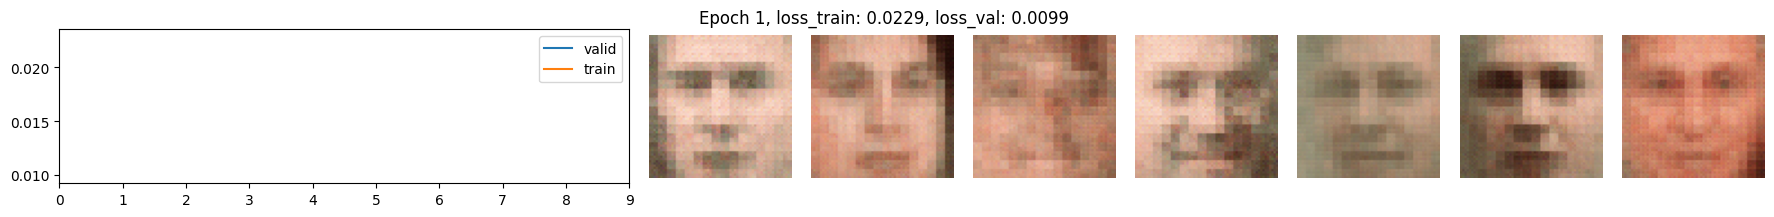

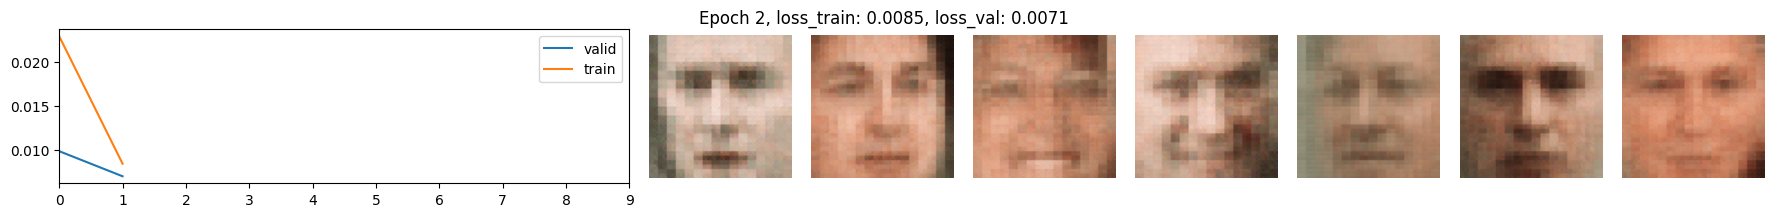

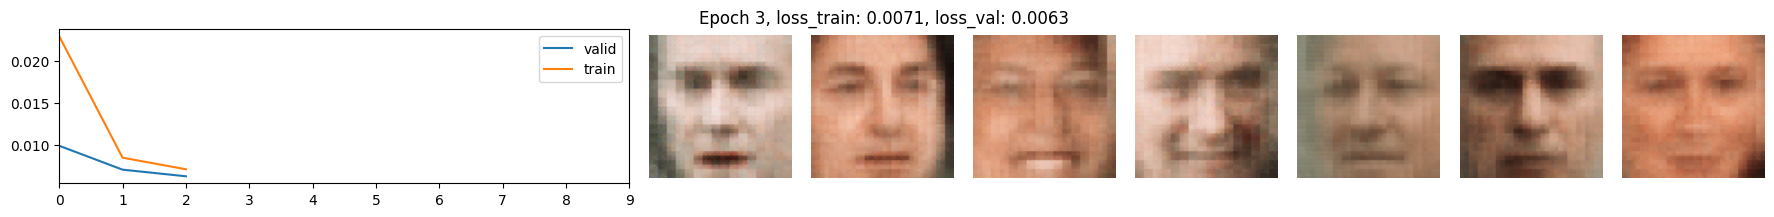

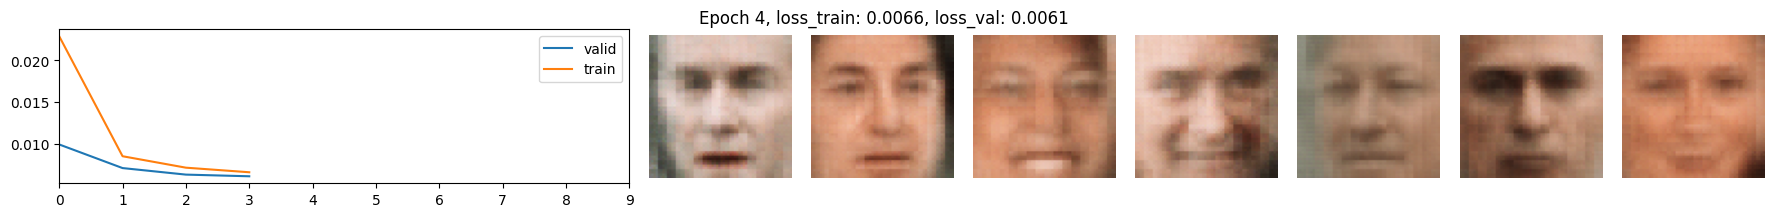

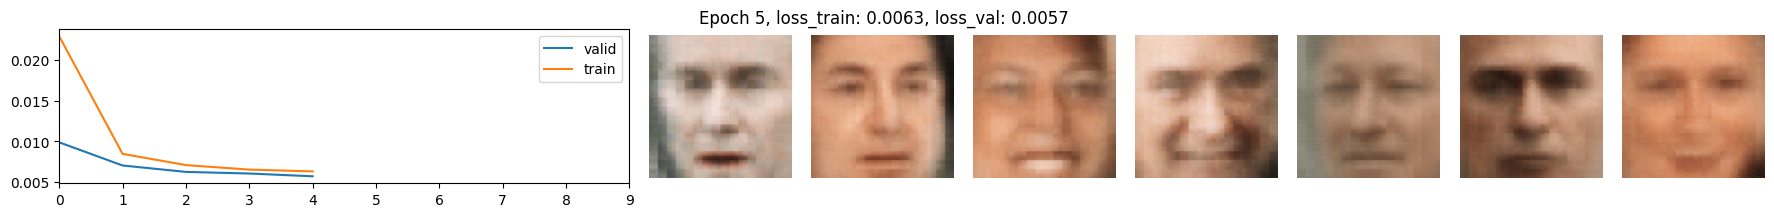

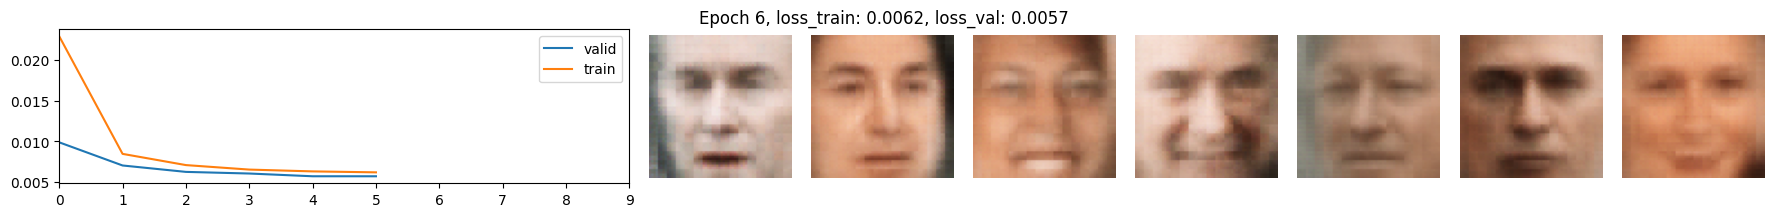

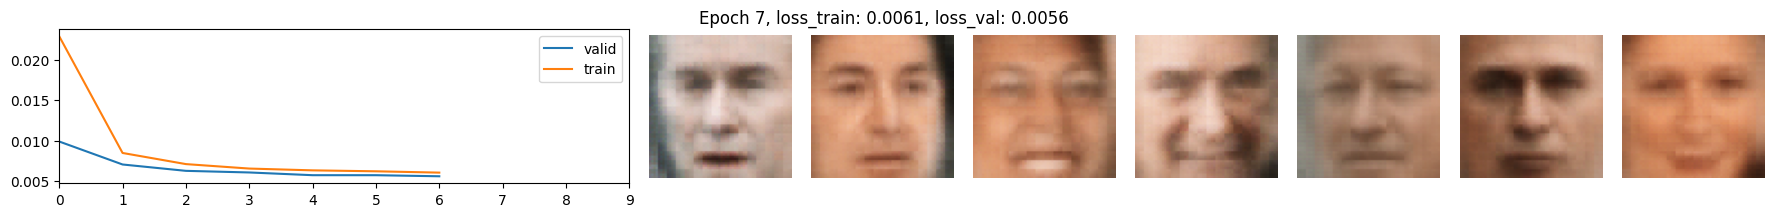

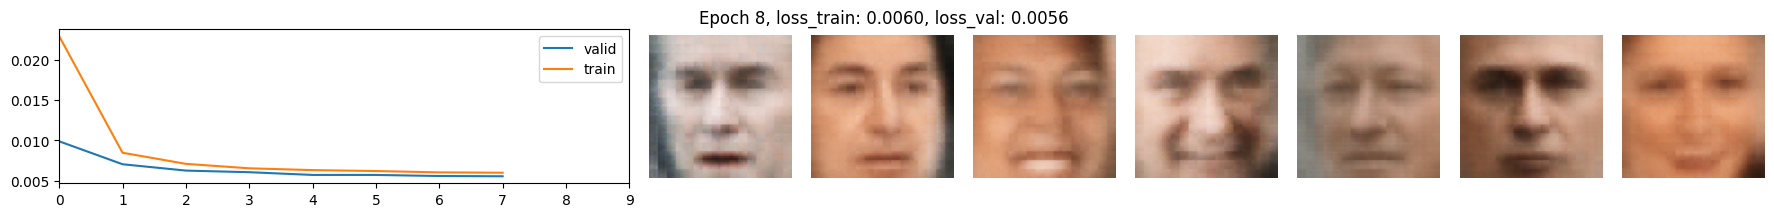

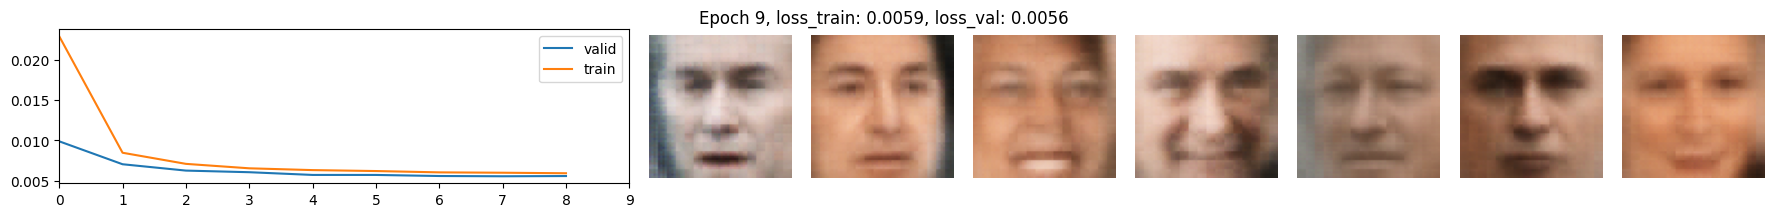

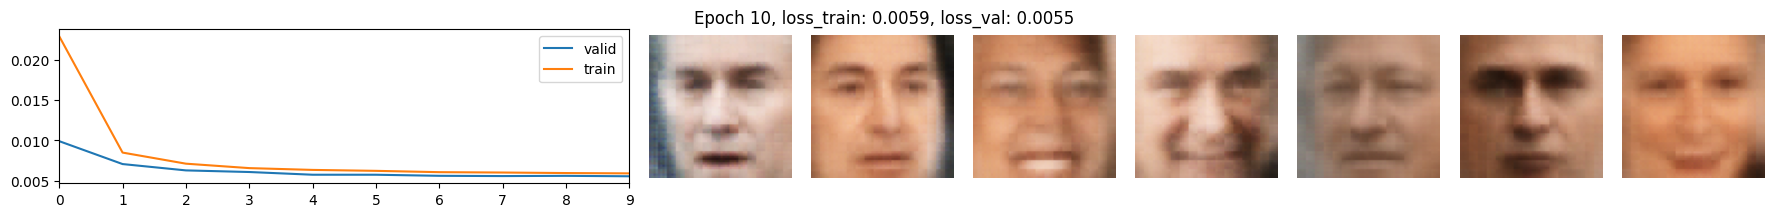

In [ ]:
train(autoencoder, train_dataloader, valid_dataloader, criterion, optimizer, epoch_number=10)

Давайте посмотрим, как наш тренированный автоэекодер кодирует и восстанавливает картинки:

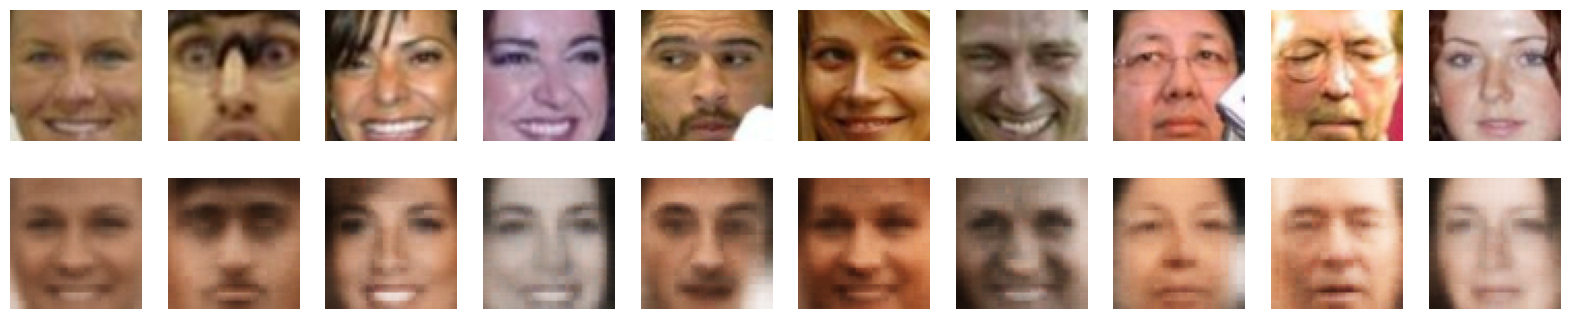

In [ ]:
#< тут Ваш код: выведите первые Х картинок и их реконструкций из val выборки на экран>

def compare_image(x):
    fg, axes = plt.subplots(2, x)
    fg.set_size_inches(x*2, 4)
    for i, v  in enumerate(axes.flatten()):
        if i < x:
            v.imshow(valid_set[i].permute(1,2,0))
        else:
            img, _ = autoencoder(valid_set[i-x].to(device).unsqueeze(0))
            v.imshow(img[0].permute(1,2,0).detach().cpu())
        v.axis("off")

compare_image(10)

Not bad, right?

## 1.4. Sampling (2 балла)

Давайте теперь будем не просто брать картинку, прогонять ее через автоэекодер и получать реконструкцию, а попробуем создать что-то НОВОЕ

Давайте возьмем и подсунем декодеру какие-нибудь сгенерированные нами векторы (например, из нормального распределения) и посмотрим на результат реконструкции декодера:

__Подсказка:__Е сли вместо лиц у вас выводится непонятно что, попробуйте посмотреть, как выглядят латентные векторы картинок из датасета. Так как в обучении нейронных сетей есть определенная доля рандома, векторы латентного слоя могут быть распределены НЕ как `np.random.randn(25, <latent_space_dim>)`. А чтобы у нас получались лица при запихивании вектора декодеру, вектор должен быть распределен так же, как латентные векторы реальных фоток. Так что в таком случае придется рандом немного подогнать.

In [1]:
# сгенерируем 25 рандомных векторов размера latent_space
z = np.random.randn(25, dim_code)
output = autoencoder.latent_to_image(torch.from_numpy(z).float().to(device))

fg, axes = plt.subplots(5, 5)
fg.set_size_inches(10,10)
for i, v in enumerate(axes.flatten()):
    v.imshow(output[i].detach().cpu().permute(1,2,0))
    v.axis("off")

NameError: name 'np' is not defined

## 1.5 Time to make fun! (4 балла)

Давайте научимся пририсовывать людям улыбки =)

<img src="https://i.imgur.com/tOE9rDK.png" alt="linear" width="700" height="400">

План такой:

1. Нужно выделить "вектор улыбки": для этого нужно из выборки изображений найти несколько (~15) людей с улыбками и столько же без.

Найти людей с улыбками вам поможет файл с описанием датасета, скачанный вместе с датасетом. В нем указаны имена картинок и присутствубщие атрибуты (улыбки, очки...)

2. Вычислить латентный вектор для всех улыбающихся людей (прогнать их через encoder) и то же для всех грустненьких

3. Вычислить, собственно, вектор улыбки -- посчитать разность между средним латентным вектором улыбающихся людей и средним латентным вектором грустных людей

4. А теперь приделаем улыбку грустному человеку: добавим полученный в пункте 3 вектор к латентному вектору грустного человека и прогоним полученный вектор через decoder. Получим того же человека, но уже не грустненького!

In [ ]:
not_smile_indeces = attrs[attrs.loc[:, "Smiling"] < -2.5].index
smile_indeces = attrs[attrs.loc[:, "Smiling"] > 2.5].index



_, smile_latent = autoencoder(data_torch[smile_indeces].to(device).permute(0, 3, 1, 2))
_, not_smile_latent = autoencoder(data_torch[not_smile_indeces].to(device).permute(0, 3, 1, 2))
pure_smile_latent = smile_latent.mean(dim=0) - not_smile_latent.mean(dim=0)

In [ ]:
not_smile = data_torch[not_smile_indeces][:10]
reconstructed, not_smile_latent = autoencoder(not_smile.to(device).permute(0, 3, 1, 2))

now_smile_latent = not_smile_latent + pure_smile_latent
now_simle = autoencoder.latent_to_image(now_smile_latent)

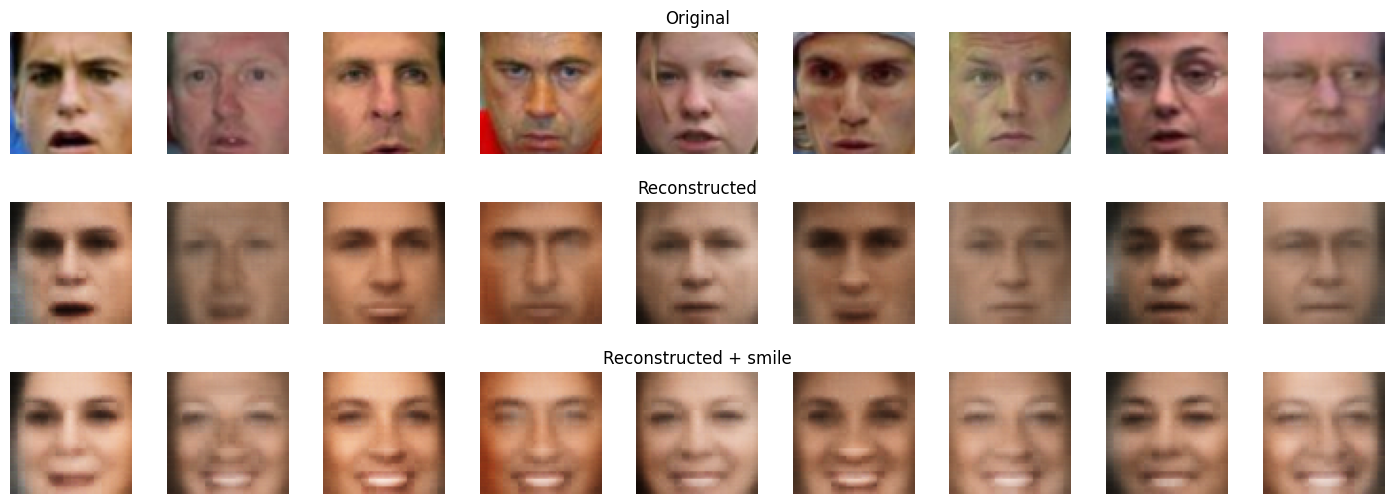

In [ ]:
x = 9
fg, axes = plt.subplots(3, x)
fg.set_size_inches(x*2, 6)
for i, v  in enumerate(axes.flatten()):
    if i < x:
        v.imshow(not_smile[i])
    elif i <2*x:
        v.imshow(reconstructed[i-x].permute(1,2,0).detach().cpu())
    else:
        v.imshow(now_simle[i-2*x].permute(1,2,0).detach().cpu())

    v.axis("off")
fg.subplots_adjust(wspace=0.1, hspace=0.4)
axes[0,4].set_title("Original")
axes[1,4].set_title("Reconstructed")
axes[2,4].set_title("Reconstructed + smile");

Вуаля! Вы восхитительны!

Теперь вы можете пририсовывать людям не только улыбки, но и много чего другого -- закрывать/открывать глаза, пририсовывать очки... в общем, все, на что хватит фантазии и на что есть атрибуты в `all_attrs`:)

# Часть 2: Variational Autoencoder (10 баллов)

Займемся обучением вариационных автоэнкодеров — проапгрейженной версии AE. Обучать будем на датасете MNIST, содержащем написанные от руки цифры от 0 до 9

In [ ]:
batch_size = 32
# MNIST Dataset
train_dataset = datasets.MNIST(root='./mnist_data/', train=True, transform=transforms.ToTensor(), download=True)
test_dataset = datasets.MNIST(root='./mnist_data/', train=False, transform=transforms.ToTensor(), download=False)

# Data Loader (Input Pipeline)
train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=False)

## 2.1 Архитектура модели и обучение (2 балла)

Реализуем VAE. Архитектуру (conv, fully-connected, ReLu, etc) можете выбирать сами. Рекомендуем пользоваться более сложными моделями, чем та, что была на семинаре:) Экспериментируйте!

In [ ]:
dim_code = 16

class VAE(nn.Module):
    def __init__(self):
        super(VAE, self).__init__()
        # Define the architectures of encoder and decoder
        # Remember, the encoder should have two "tails",
        # i.e., the encoder should encode the image into 2 variables -- mu and logsigma
        self.encoder = nn.Sequential(
            nn.Conv2d(1, 16, 3, stride=2, padding=1),
            nn.ReLU(),
            nn.Conv2d(16, 32, 3, stride=2, padding=1),
            nn.ReLU(),
            nn.Flatten(),
            nn.Linear(32 * 7 * 7, 256),
            nn.ReLU()
        )

        self.fc_mu = nn.Linear(256, dim_code)
        self.fc_sigma = nn.Sequential(
            nn.Linear(256, dim_code),
            nn.Sigmoid()
        )

        self.decoder = nn.Sequential(
            nn.Linear(dim_code, 256),
            nn.ReLU(),
            nn.Linear(256, 32 * 7 * 7),
            nn.ReLU(),
            nn.Unflatten(1, (32, 7, 7)),
            nn.ConvTranspose2d(32, 16, 3, stride=2, padding=1, output_padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(16, 1, 3, stride=2, padding=1, output_padding=1),
            nn.Sigmoid()
        )

    def encode(self, x):
        encoded = self.encoder(x)
        mu = self.fc_mu(encoded)

        logsigma = self.fc_sigma(encoded).log()
        return mu, logsigma

    def gaussian_sampler(self, mu, logsigma):
        if self.training:
            std = torch.exp(0.5 * logsigma)
            epsilon = torch.randn_like(std)
            z = mu + epsilon * std
            return z
        else:
            return mu

    def decode(self, z):
        reconstruction = self.decoder(z)
        return reconstruction

    def forward(self, x):
        mu, logsigma = self.encode(x)
        z = self.gaussian_sampler(mu, logsigma)
        reconstruction = self.decode(z)
        return mu, logsigma, reconstruction

Определим лосс и его компоненты для VAE:

Надеюсь, вы уже прочитали материал в towardsdatascience (или еще где-то) про VAE и знаете, что лосс у VAE состоит из двух частей: KL и log-likelihood.

Общий лосс будет выглядеть так:

$$\mathcal{L} = -D_{KL}(q_{\phi}(z|x)||p(z)) + \log p_{\theta}(x|z)$$

Формула для KL-дивергенции:

$$D_{KL} = -\frac{1}{2}\sum_{i=1}^{dimZ}(1+log(\sigma_i^2)-\mu_i^2-\sigma_i^2)$$

В качестве log-likelihood возьмем привычную нам кросс-энтропию.

In [ ]:
def KL_divergence(mu, logsigma):
    """
    часть функции потерь, которая отвечает за "близость" латентных представлений разных людей
    """
    loss = -(1/2) * (1+ logsigma - mu**2 - logsigma.exp()**2).sum()
    return loss

def log_likelihood(x, reconstruction):
    """
    часть функции потерь, которая отвечает за качество реконструкции (как mse в обычном autoencoder)
    """
    loss = nn.BCELoss(reduction="sum")
    return loss(reconstruction, x)

def loss_vae(x, mu, logsigma, reconstruction):
    return KL_divergence(mu, logsigma) + log_likelihood(x, reconstruction)

И обучим модель:

In [ ]:
criterion = loss_vae

autoencoder = VAE().to(device)

optimizer = torch.optim.AdamW(autoencoder.parameters())

In [ ]:
def train(model, train_dataloader, valid_dataloader, loss_func, optimizer, epoch_number=10):
    train_loss_history, valid_loss_history = [], []

    latent_representation_valid = [] # сохраняем латентные представления для одного из следующих заданий

    for epoch in range(1, epoch_number+1):
        model.train()
        train_loss = 0
        for image, labels in train_dataloader:
            image = image.to(device)
            mu, logsigma, reconstruction = model(image)
            loss = loss_func(image, mu, logsigma, reconstruction)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            train_loss += loss.cpu().item()
        train_loss = train_loss / len(train_dataloader)
        train_loss_history.append(train_loss)

        model.eval()
        valid_loss = 0
        with torch.no_grad():

            for image, labels in valid_dataloader:
                image = image.to(device)
                mu, logsigma, reconstruction = model(image)
                if epoch==epoch_number:
                    latent_representation_valid.append((mu, labels))
                loss = loss_func(image, mu, logsigma, reconstruction)
                valid_loss += loss.cpu().item()
        valid_loss = valid_loss / len(valid_dataloader)
        valid_loss_history.append(valid_loss)

        fg, axes = plt.subplots(1, 8, gridspec_kw={'width_ratios': [4, 1,1,1,1,1,1,1]})
        fg.set_size_inches(22,2)
        fg.suptitle(f"Epoch {epoch}, loss_train: {train_loss:.4f}, loss_val: {valid_loss:.4f}")
        fg.subplots_adjust(wspace=0.1, hspace=0.1)

        axes[0].plot(valid_loss_history, label="valid")
        axes[0].plot(train_loss_history, label="train")
        axes[0].set_xlim(0, epoch_number-1)
        axes[0].legend()
        # axes[0].set_aspect(0.5)
        for i, v in enumerate(axes.flatten()[1:]):
            v.axis('off')
            v.imshow(reconstruction[i].cpu().permute(1,2,0))
        plt.show()
    return latent_representation_valid

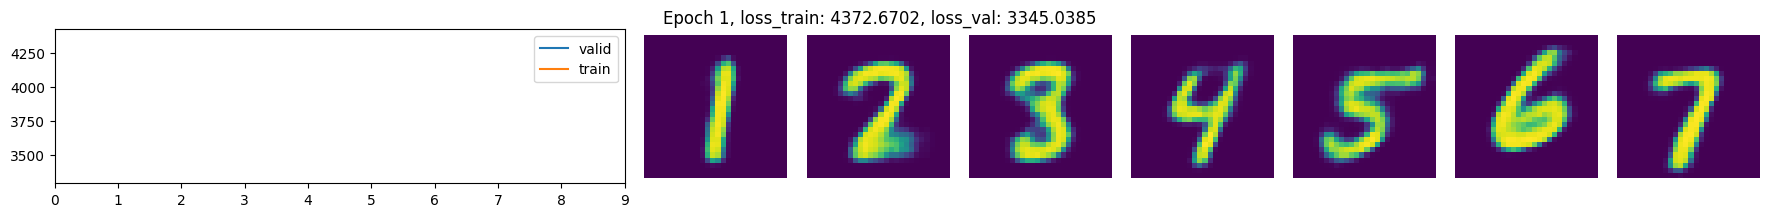

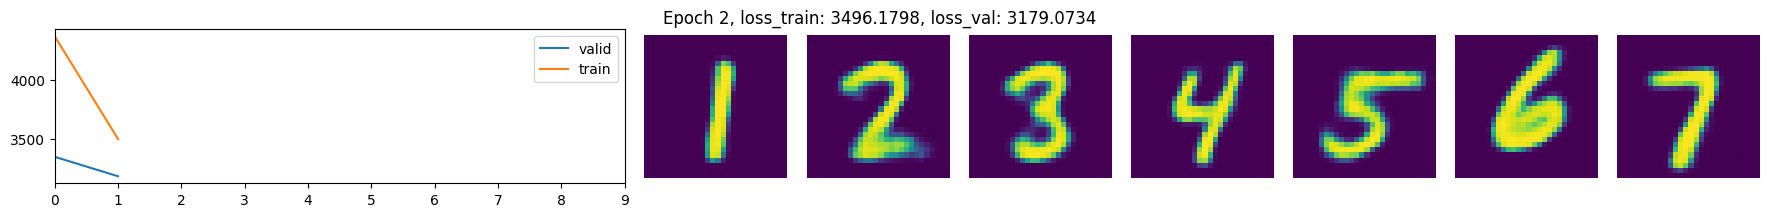

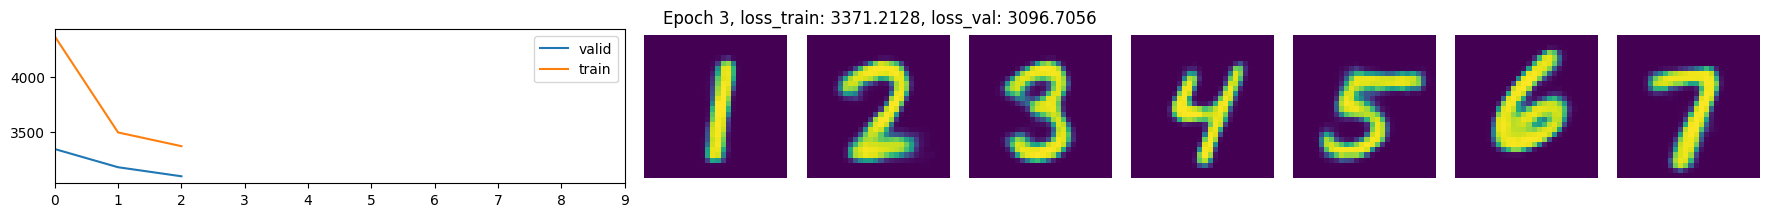

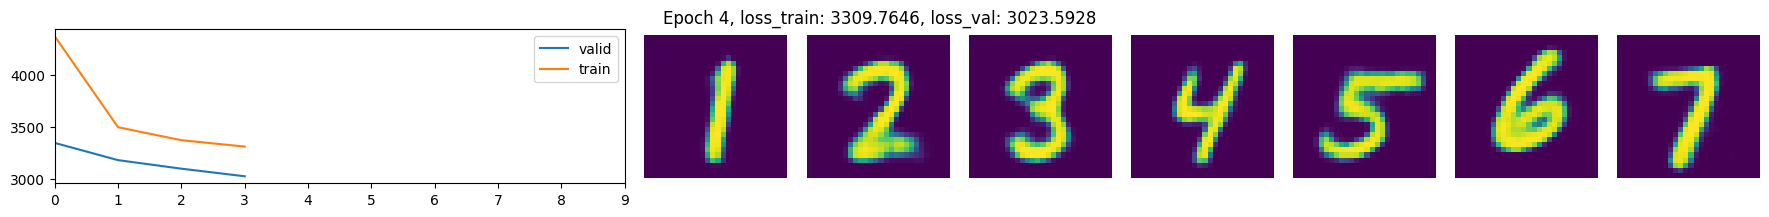

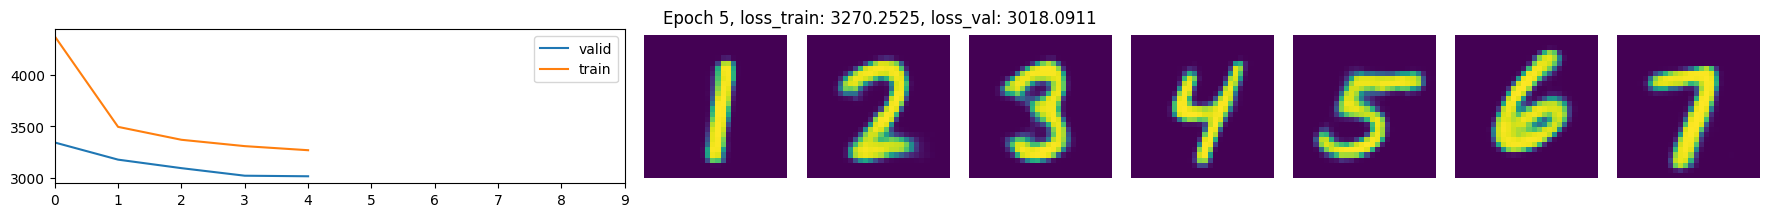

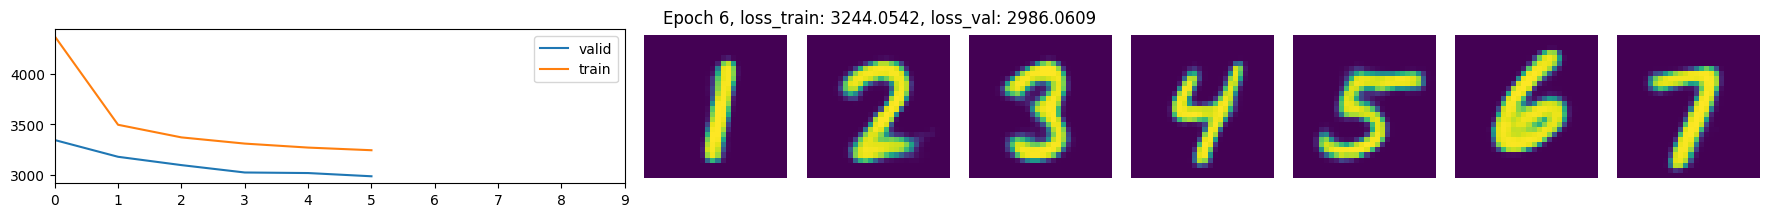

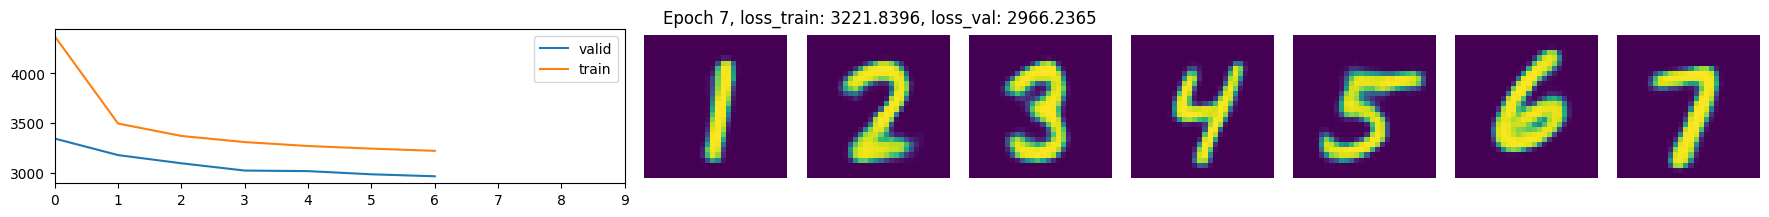

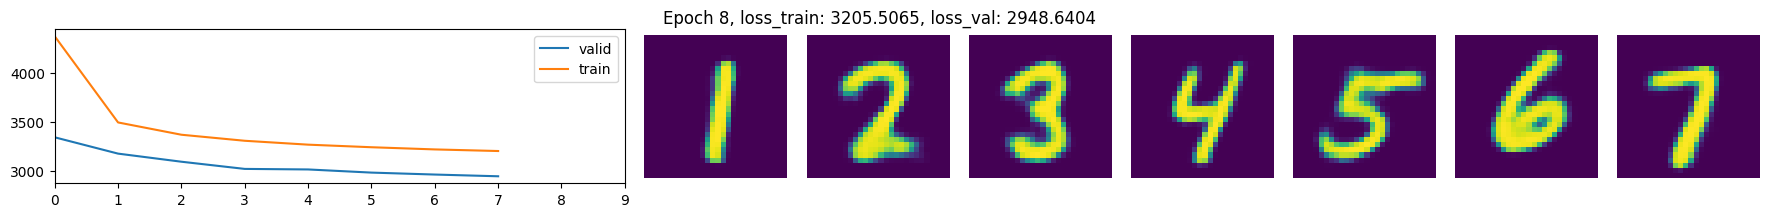

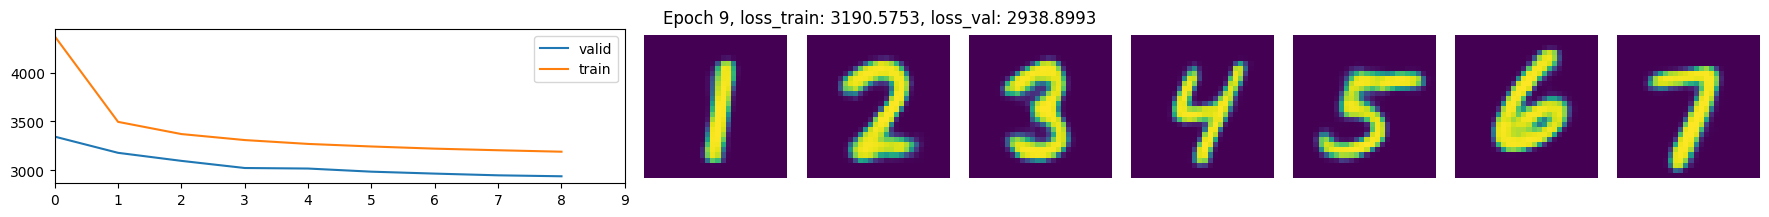

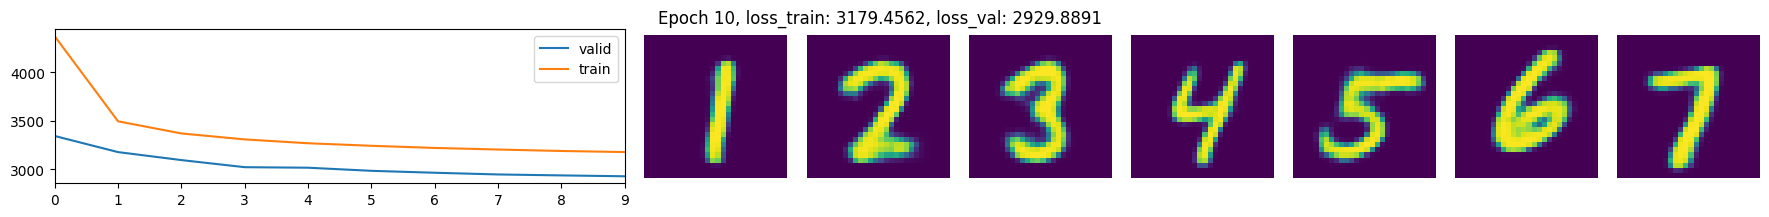

In [ ]:
latent_representation_valid = train(autoencoder, train_loader, test_loader, criterion, optimizer, epoch_number=10)

Давайте посмотрим, как наш тренированный VAE кодирует и восстанавливает картинки:

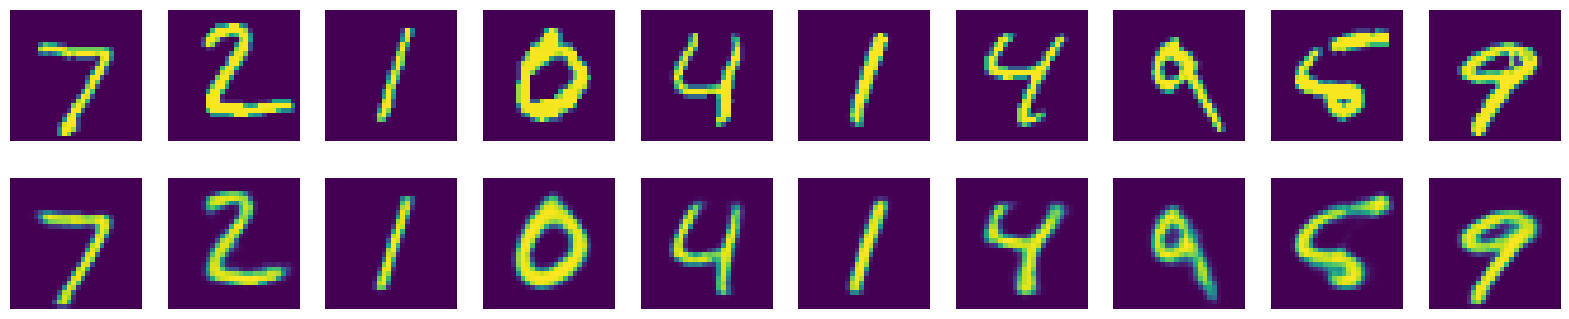

In [ ]:
def compare_image(x):
    fg, axes = plt.subplots(2, x)
    fg.set_size_inches(x*2, 4)
    for i, v  in enumerate(axes.flatten()):
        if i < x:
            v.imshow(test_dataset[i][0].permute(1,2,0))
        else:
            _, _, img = autoencoder(test_dataset[i-x][0].to(device).unsqueeze(0))
            v.imshow(img[0].permute(1,2,0).detach().cpu())
        v.axis("off")

compare_image(10)

Давайте попробуем проделать для VAE то же, что и с обычным автоэнкодером -- подсунуть decoder'у из VAE случайные векторы из нормального распределения и посмотреть, какие картинки получаются:

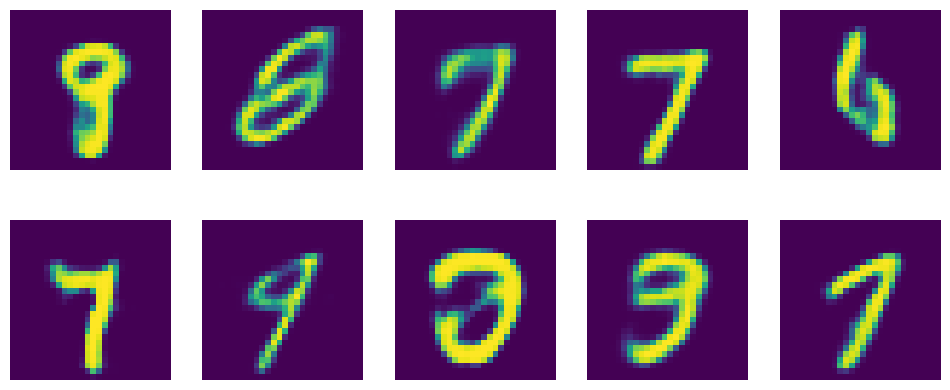

In [ ]:
# вспомните про замечание из этого же пункта обычного AE про распределение латентных переменных
z = np.array([np.random.normal(0, 1, dim_code) for i in range(10)])
output = autoencoder.decode(torch.from_numpy(z).to(device).float())

fg, axes = plt.subplots(2, 5)
fg.set_size_inches(12,5)
for i, v in enumerate(axes.flatten()):
    v.imshow(output[i].detach().cpu().permute(1,2,0))
    v.axis("off")

## 2.2. Latent Representation (2 балла)

Давайте посмотрим, как латентные векторы картинок лиц выглядят в пространстве.
Ваша задача -- изобразить латентные векторы картинок точками в двумерном просторанстве.

Это позволит оценить, насколько плотно распределены латентные векторы изображений цифр в пространстве.

Плюс давайте сделаем такую вещь: покрасим точки, которые соответствуют картинкам каждой цифры, в свой отдельный цвет

Подсказка: красить -- это просто =) У plt.scatter есть параметр c (color), см. в документации.


Итак, план:
1. Получить латентные представления картинок тестового датасета
2. С помощтю `TSNE` (есть в `sklearn`) сжать эти представления до размерности 2 (чтобы можно было их визуализировать точками в пространстве)
3. Визуализировать полученные двумерные представления с помощью `matplotlib.scatter`, покрасить разными цветами точки, соответствующие картинкам разных цифр.

In [ ]:
from sklearn.manifold import TSNE
latent_representation_valid_flatted = [(x[0][z].detach().cpu().numpy(), x[1][z].detach().cpu().numpy()) for x in latent_representation_valid for z in range(len(x))]


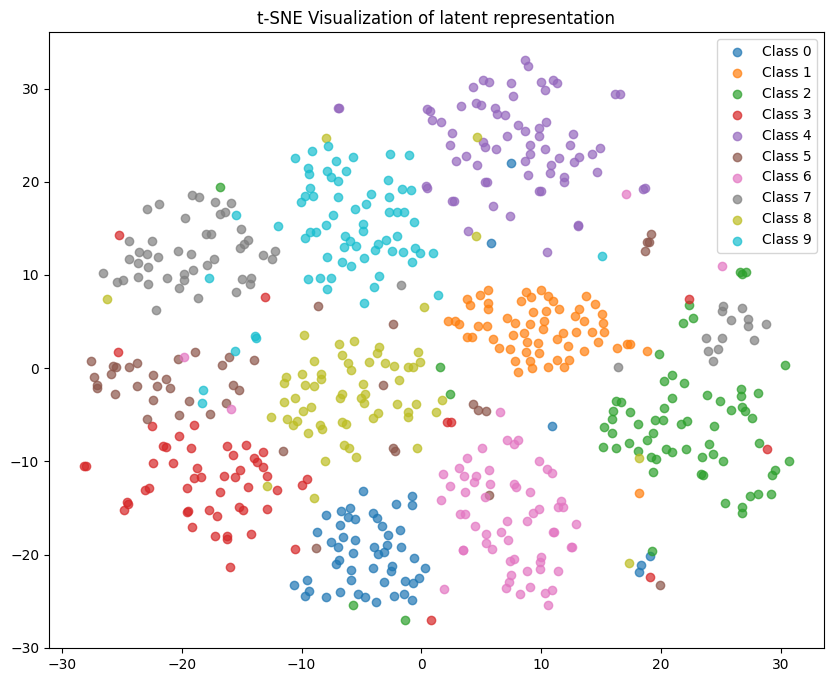

In [ ]:
X = np.array([d[0] for d in latent_representation_valid_flatted])
y = np.array([d[1] for d in latent_representation_valid_flatted])

# Perform t-SNE
tsne = TSNE(n_components=2)
X_tsne = tsne.fit_transform(X)

# Plot the embeddings
plt.figure(figsize=(10, 8))
for i in range(10):  # Assuming 10 unique class labels
    plt.scatter(
        X_tsne[y == i, 0],
        X_tsne[y == i, 1],
        label=f"Class {i}",
        alpha=0.7
    )
plt.legend()
plt.title("t-SNE Visualization of latent representation")
plt.show()

Что вы думаете о виде латентного представления?

Можно сказать, что классы разделимы, как в оригинальном латентном пространстве так и в его двухмерном представлении полученом при помощи алгоритма t-SNE

__Congrats v2.0!__

## 2.3. Conditional VAE (6 баллов)


Мы уже научились обучать обычный AE на датасете картинок и получать новые картинки, используя генерацию шума и декодер.
Давайте теперь допустим, что мы обучили AE на датасете MNIST и теперь хотим генерировать новые картинки с числами с помощью декодера (как выше мы генерили рандомные лица).
И вот нам понадобилось сгенерировать цифру 8, и мы подставляем разные варианты шума, но восьмерка никак не генерится:(

Хотелось бы добавить к нашему AE функцию "выдай мне рандомное число из вот этого вот класса", где классов десять (цифры от 0 до 9 образуют десять классов).  Conditional AE — так называется вид автоэнкодера, который предоставляет такую возможность. Ну, название "conditional" уже говорит само за себя.

И в этой части задания мы научимся такие обучать.

### Архитектура

На картинке ниже представлена архитектура простого Conditional VAE.

По сути, единственное отличие от обычного -- это то, что мы вместе с картинкой в первом слое энкодера и декодера передаем еще информацию о классе картинки.

То есть, в первый (входной) слой энкодера подается конкатенация картинки и информации о классе (например, вектора из девяти нулей и одной единицы). В первый слой декодера подается конкатенация латентного вектора и информации о классе.


![alt text](https://sun9-63.userapi.com/impg/Mh1akf7mfpNoprrSWsPOouazSmTPMazYYF49Tw/djoHNw_9KVA.jpg?size=1175x642&quality=96&sign=e88baec5f9bb91c8443fba31dcf0a4df&type=album)



На всякий случай: это VAE, то есть, latent у него все еще состоит из mu и sigma

Таким образом, при генерации новой рандомной картинки мы должны будем передать декодеру сконкатенированные латентный вектор и класс картинки.

P.S. Также можно передавать класс картинки не только в первый слой, но и в каждый слой сети. То есть на каждом слое конкатенировать выход из предыдущего слоя и информацию о классе.

In [ ]:
dim_code = 10

class CVAE(nn.Module):
    def __init__(self, num_classes):
        super(CVAE, self).__init__()
        self.num_classes = num_classes

        # Define the architectures of encoder and decoder
        # Remember, the encoder should have two "tails",
        # i.e., the encoder should encode the image into 2 variables -- mu and logsigma

        self.encoder = nn.Sequential(
            nn.Conv2d(1, 16, 3, stride=2, padding=1),
            nn.ReLU(),
            nn.Conv2d(16, 32, 3, stride=2, padding=1),
            nn.ReLU(),
            nn.Flatten(),
            nn.Linear(32 * 7 * 7, 256),
            nn.ReLU()
        )

        self.fc_mu = nn.Linear(256, dim_code)
        self.fc_logsigma = nn.Linear(256, dim_code)
        self.fc_class = nn.Linear(256, num_classes)

        self.decoder = nn.Sequential(
            nn.Linear(dim_code + num_classes, 256),
            nn.ReLU(),
            nn.Linear(256, 32 * 7 * 7),
            nn.ReLU(),
            nn.Unflatten(1, (32, 7, 7)),
            nn.ConvTranspose2d(32, 16, 3, stride=2, padding=1, output_padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(16, 1, 3, stride=2, padding=1, output_padding=1),
            nn.Sigmoid()
        )

    def encode(self, x, class_num):
        encoded = self.encoder(x)
        mu = self.fc_mu(encoded)
        logsigma = self.fc_logsigma(encoded)
        class_output = self.fc_class(encoded)
        return mu, logsigma, class_output

    def gaussian_sampler(self, mu, logsigma):
        if self.training:
            std = torch.exp(0.5 * logsigma)
            epsilon = torch.randn_like(std)
            z = mu + epsilon * std
            return z
        else:
            return mu

    def decode(self, z, class_num):
        combined_input = torch.cat((z, class_num), dim=1)
        reconstruction = self.decoder(combined_input)
        return reconstruction

    def forward(self, x, class_num):
        mu, logsigma, class_output = self.encode(x, class_num)
        z = self.gaussian_sampler(mu, logsigma)
        combined_class = F.one_hot(class_num, num_classes=self.num_classes).float()
        reconstruction = self.decode(z, combined_class)
        extande_z = torch.cat((combined_class, z), dim=1)
        return mu, logsigma, reconstruction, extande_z

In [ ]:
criterion = loss_vae

conditional_autoencoder = CVAE(10).to(device)

optimizer = torch.optim.AdamW(conditional_autoencoder.parameters())

In [ ]:
def train(model, train_dataloader, valid_dataloader, loss_func, optimizer, epoch_number=10):
    train_loss_history, valid_loss_history = [], []

    latent_representation_valid = [] # сохраняем латентные представления для одного из следующих заданий

    for epoch in range(1, epoch_number+1):
        model.train()
        train_loss = 0
        for image, labels in train_dataloader:
            image = image.to(device)
            labels = labels.to(device)
            mu, logsigma, reconstruction, combined_class = model(image, labels)
            loss = loss_func(image, mu, logsigma, reconstruction)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            train_loss += loss.cpu().item()
        train_loss = train_loss / len(train_dataloader)
        train_loss_history.append(train_loss)

        model.eval()
        valid_loss = 0
        with torch.no_grad():

            for image, labels in valid_dataloader:
                image = image.to(device)
                labels = labels.to(device)
                mu, logsigma, reconstruction, combined_class = model(image, labels)
                if epoch==epoch_number:
                    latent_representation_valid.append((combined_class, labels))
                loss = loss_func(image, mu, logsigma, reconstruction)
                valid_loss += loss.cpu().item()
        valid_loss = valid_loss / len(valid_dataloader)
        valid_loss_history.append(valid_loss)

        fg, axes = plt.subplots(1, 8, gridspec_kw={'width_ratios': [4, 1,1,1,1,1,1,1]})
        fg.set_size_inches(22,2)
        fg.suptitle(f"Epoch {epoch}, loss_train: {train_loss:.4f}, loss_val: {valid_loss:.4f}")
        fg.subplots_adjust(wspace=0.1, hspace=0.1)

        axes[0].plot(valid_loss_history, label="valid")
        axes[0].plot(train_loss_history, label="train")
        axes[0].set_xlim(0, epoch_number-1)
        axes[0].legend()
        # axes[0].set_aspect(0.5)
        for i, v in enumerate(axes.flatten()[1:]):
            v.axis('off')
            v.imshow(reconstruction[i].cpu().permute(1,2,0))
        plt.show()
    return latent_representation_valid

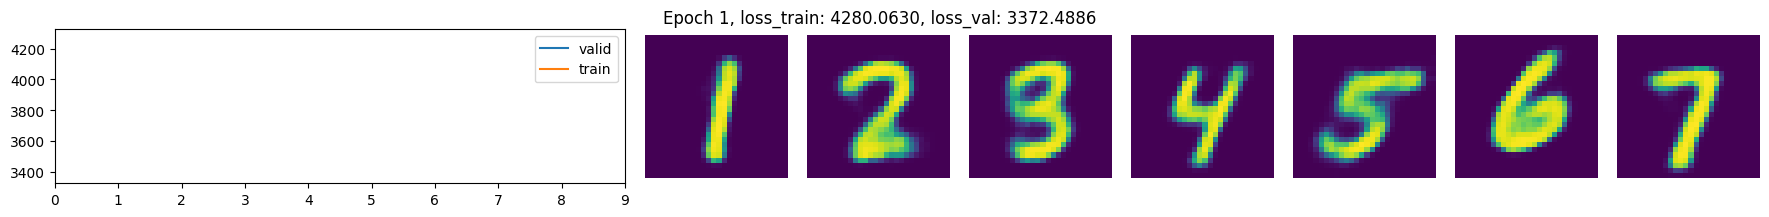

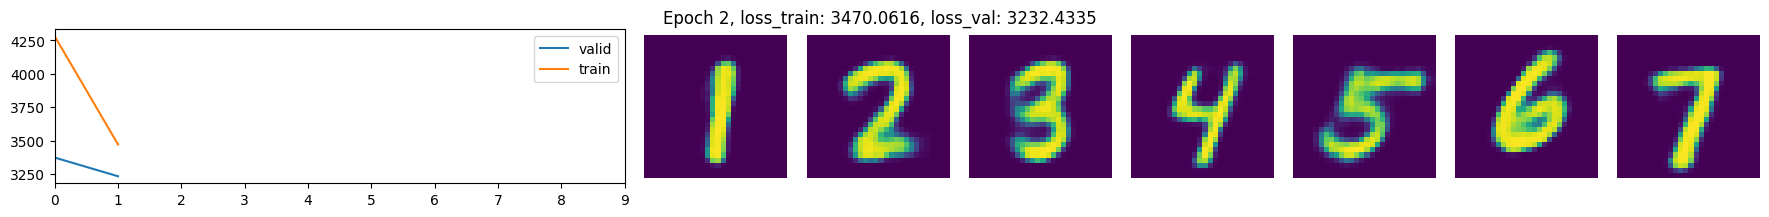

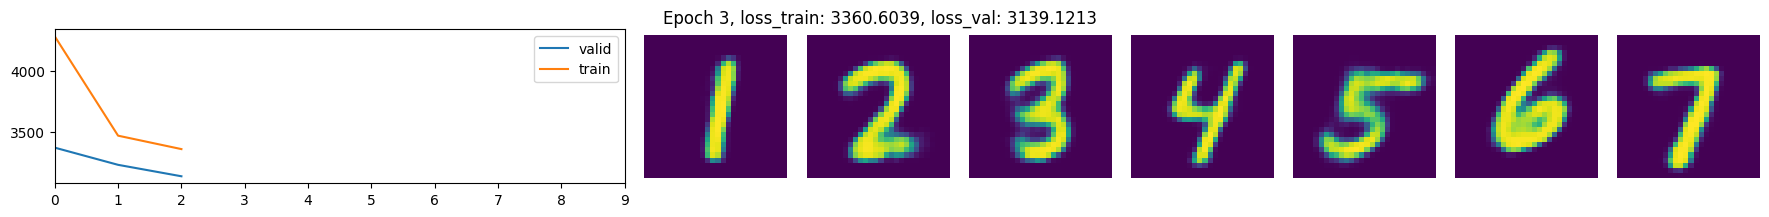

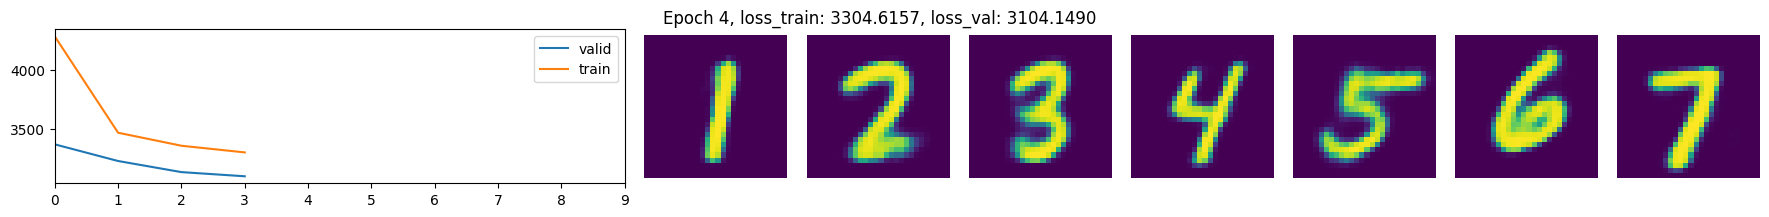

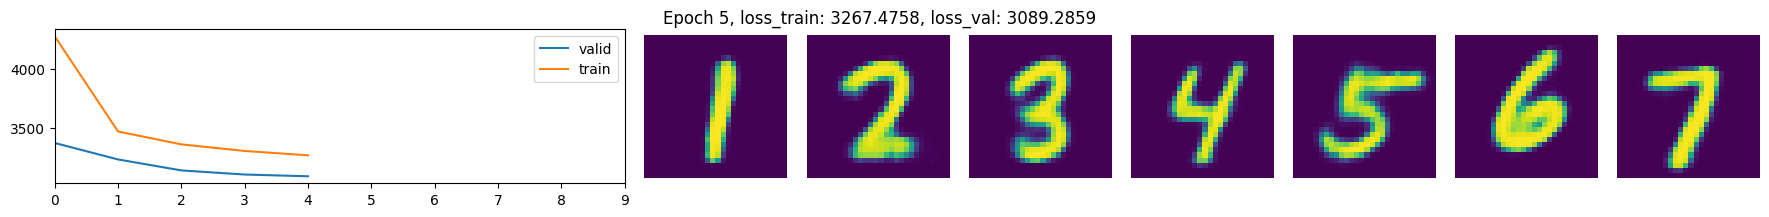

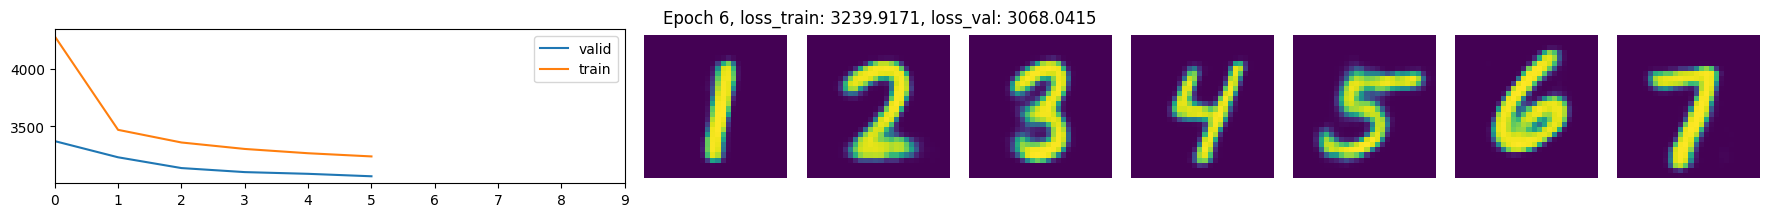

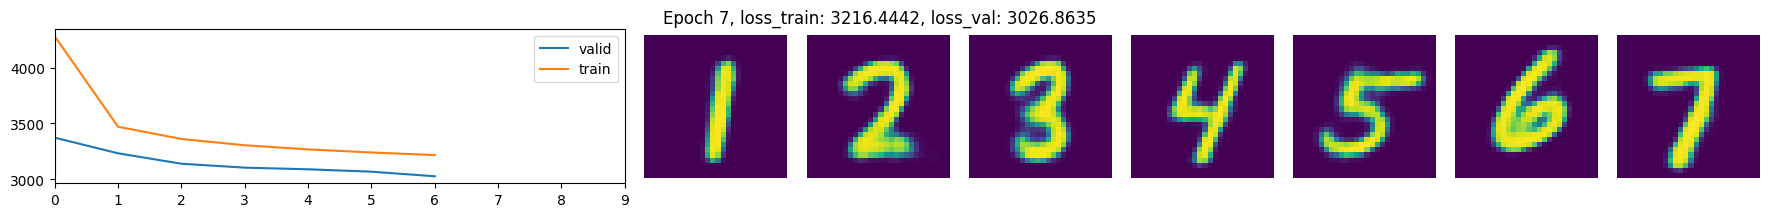

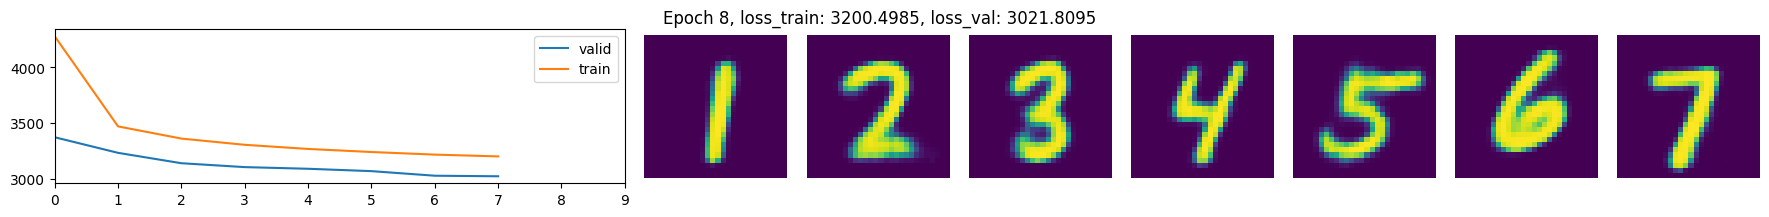

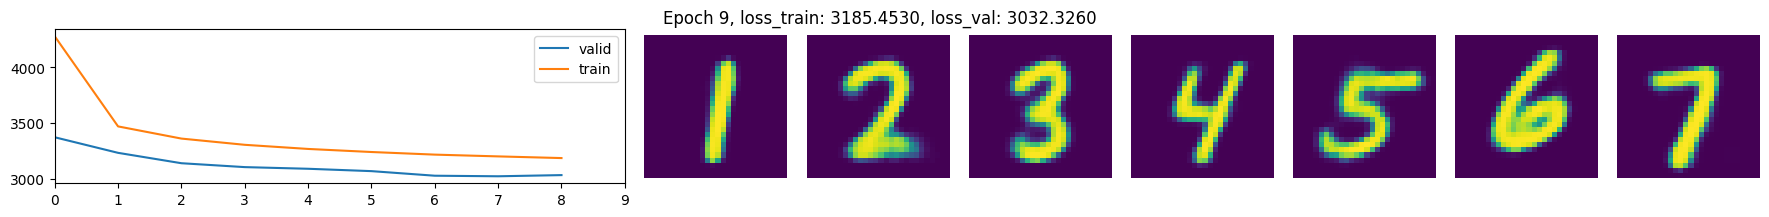

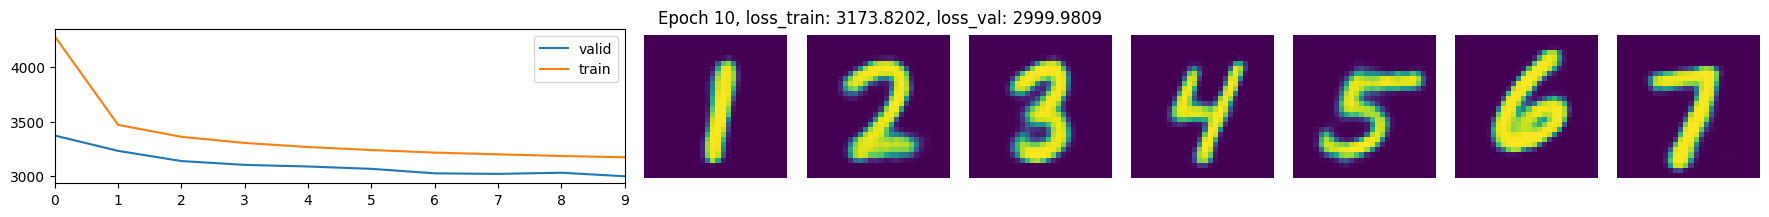

In [ ]:
latent_representation_valid = train(conditional_autoencoder, train_loader, test_loader, criterion, optimizer, epoch_number=10)

### Sampling


Тут мы будем сэмплировать из CVAE. Это прикольнее, чем сэмплировать из простого AE/VAE: тут можно взять один и тот же латентный вектор и попросить CVAE восстановить из него картинки разных классов!
Для MNIST вы можете попросить CVAE восстановить из одного латентного вектора, например, картинки цифры 5 и 7.

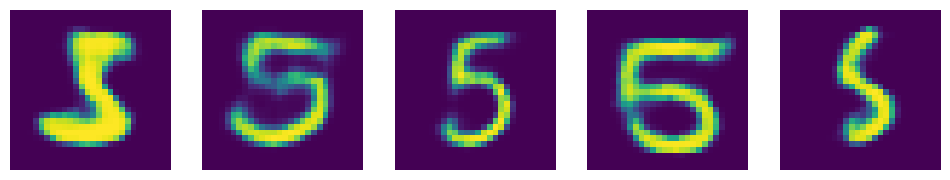

In [ ]:
# вспомните про замечание из этого же пункта обычного AE про распределение латентных переменных
z = np.array([np.random.normal(0, 1, dim_code) for i in range(5)])
output = conditional_autoencoder.decode(torch.from_numpy(z).to(device).float(), F.one_hot(torch.tensor([5]*5), num_classes=10).to(device).float())

fg, axes = plt.subplots(1, 5)
fg.set_size_inches(12,5)
for i, v in enumerate(axes.flatten()):
    v.imshow(output[i].detach().cpu().permute(1,2,0))
    v.axis("off")

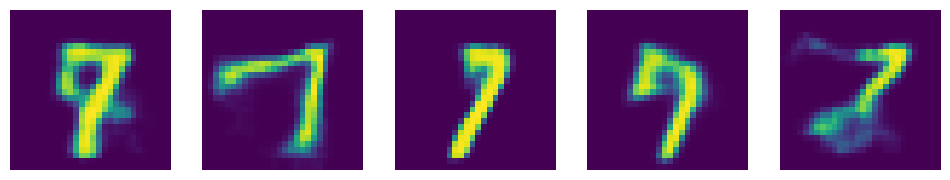

In [ ]:
z = np.array([np.random.normal(0, 1, dim_code) for i in range(5)])
output = conditional_autoencoder.decode(torch.from_numpy(z).to(device).float(), F.one_hot(torch.tensor([7]*5), num_classes=10).to(device).float())

fg, axes = plt.subplots(1, 5)
fg.set_size_inches(12,5)
for i, v in enumerate(axes.flatten()):
    v.imshow(output[i].detach().cpu().permute(1,2,0))
    v.axis("off")

Splendid! Вы великолепны!


### Latent Representations

Давайте посмотрим, как выглядит латентное пространство картинок в CVAE и сравним с картинкой для VAE =)

Опять же, нужно покрасить точки в разные цвета в зависимости от класса.

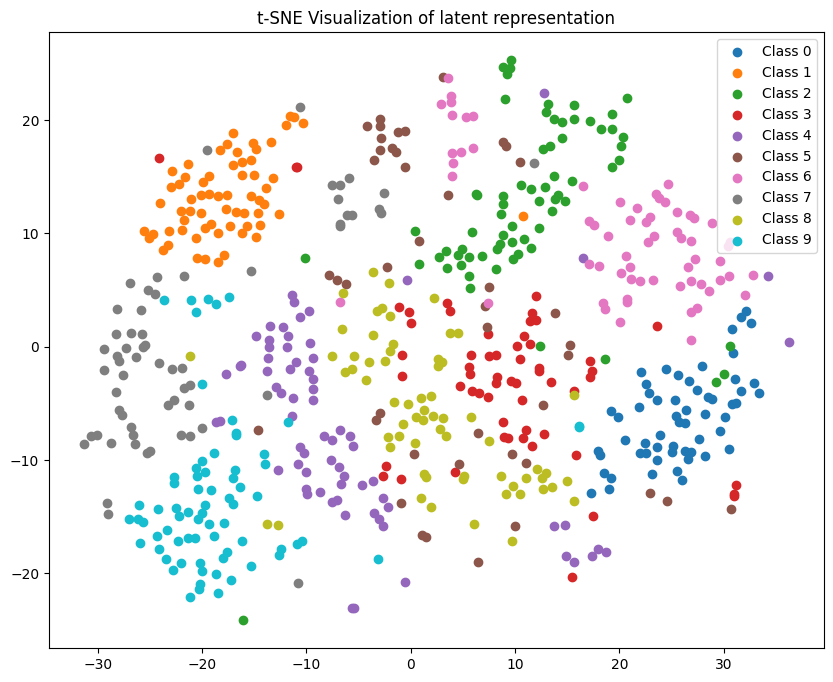

In [ ]:
latent_representation_valid_flatted = [(x[0][z].detach().cpu().numpy(), x[1][z].detach().cpu().numpy()) for x in latent_representation_valid for z in range(len(x))]

X = np.array([d[0] for d in latent_representation_valid_flatted])
y = np.array([d[1] for d in latent_representation_valid_flatted])

# Perform t-SNE
tsne = TSNE(n_components=2)
X_tsne = tsne.fit_transform(X)

# Plot the embeddings
plt.figure(figsize=(10, 8))
for i in range(10):  # Assuming 10 unique class labels
    plt.scatter(
        X_tsne[y == i, 0],
        X_tsne[y == i, 1],
        label=f"Class {i}",
        alpha=1
    )
plt.legend()
plt.title("t-SNE Visualization of latent representation")
plt.show()

Что вы думаете насчет этой картинки? Отличается от картинки для VAE?

Классы более близки друг к другу. Похожие цифры, такие как 7 и 1 находятся рядом. В отличие от распределение VAE переход между классами более плавный.